In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from uncertainty_forest.uncertainty_forest import UncertaintyForest
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from tqdm.notebook import tqdm
from joblib import Parallel, delayed
from scipy.stats import entropy, norm
from scipy.integrate import quad

## Simulate Data and Conditional Entropy Prediction

In [2]:
def generate_data(n, d, frac_eval, mu = 1):
    n_1 = np.random.binomial(n, .5) # number of class 1
    mean = np.zeros(d)
    mean[0] = mu
    X_1 = np.random.multivariate_normal(mean, np.eye(d), n_1)
    
    X = np.concatenate((X_1, np.random.multivariate_normal(-mean, np.eye(d), n - n_1)))
    y = np.concatenate((np.repeat(1, n_1), np.repeat(-1, n - n_1)))
    
    # Evaluation data.
    if frac_eval == 0:
        return X, y
    n_eval = int(np.floor(frac_eval*n))
    eval_indices = np.random.choice(np.arange(n), size = n_eval, replace = False)
    X_eval = X[eval_indices, :]
    X = np.delete(X, eval_indices, axis = 0)
    y = np.delete(y, eval_indices, axis = 0)
    return X, y, X_eval

In [3]:
def conditional_entropy_distribution(n, d, frac_eval, algos, num_trials, mu, parallel = False):
    # For each trial, generate data and compute conditional entropy for each algorithm.
    def worker(t):
        # X, y, X_eval = generate_data(n, d, frac_eval, mu = mu)
        X, y = generate_data(n, d, 0, mu = mu)
        ret = np.zeros(len(algos))
        for i in range(len(algos)):
            obj = algos[i]['instance']
            obj.fit(X, y)
            if algos[i]['label'] == 'UF':
                ret[i] = obj.estimate_cond_entropy()
            else:
                p = obj.predict_proba(X)
                ret[i] = np.mean(entropy(p.T, base = 2))
        return ret
    
    if parallel:
        predicted_cond_entropy = np.array(Parallel(n_jobs=-2)(delayed(worker)(t) for t in range(num_trials)))
    else:
        predicted_cond_entropy = np.zeros((num_trials, len(algos)))
        for t in tqdm(range(num_trials)):
            predicted_cond_entropy[t, :] = worker(t)
            
    return predicted_cond_entropy

## Compute True Conditional Entropy

In [4]:
def true_cond_entropy(mu):
    def func(x):
        p = 0.5 * norm.pdf(x, mu, 1) + 0.5 * norm.pdf(x, -mu, 1)
        return -p * np.log2(p)
    
    H_X = quad(func, -20, 20)
    H_XY = 0.5*(1.0/np.log(2.0) + np.log2(2 * np.pi))
    H_Y = 1
    # I_XY = H_X - H_XY = H_Y - H_YX
    return H_Y - H_X[0] + H_XY

## Conditional Entropy versus Sample Size

In [5]:
def conditional_entropy_by_n(sample_sizes, d, frac_eval, algos, num_trials, mu, parallel = False):
    # Repeat for all 'n', and save output in the 'algos' array.
    cond_entropy_range = np.zeros((len(sample_sizes), num_trials, len(algos)))
    for i in range(len(sample_sizes)):
        cond_entropy_range[i, :, :] = conditional_entropy_distribution(sample_sizes[i], 
                                                                       d, 
                                                                       frac_eval, 
                                                                       algos, 
                                                                       num_trials, 
                                                                       mu = mu,
                                                                       parallel = parallel)
        
    for j in range(len(algos)):
        algos[j]['cond_entropy_by_n_d_%d' % d] = cond_entropy_range[:, :, j]
        
    with open('algos_fig2.pkl', 'wb') as f:
        pickle.dump(algos, f)
    with open('sample_sizes_d_%d.pkl' % d, 'wb') as f:
        pickle.dump(sample_sizes, f)

In [6]:
def plot_cond_entropy_by_n(ax, num_plotted_trials, d, mu = 1):
    with open('sample_sizes_d_%d.pkl' % d, 'rb') as f:
        sample_sizes = pickle.load(f)
    with open('algos_fig2.pkl', 'rb') as f:
        algos = pickle.load(f)
    
    for algo in algos:
        # Plot the mean over trials as a solid line.
        ax.plot(sample_sizes,
                np.mean(algo['cond_entropy_by_n_d_%d' % d], axis = 1).flatten(), 
                label = algo['label'], 
                linewidth = 4, 
                color = algo['color'])
        # Use transparent lines to show other trials.
        for t in range(num_plotted_trials):
            ax.plot(sample_sizes, 
                    algo['cond_entropy_by_n_d_%d' % d][:, t].flatten(),  
                    linewidth = 2, 
                    color = algo['color'],
                    alpha = 0.15)
    
    truth = true_cond_entropy(mu)
    ax.axhline(y = truth, linestyle = '-', color = "black", label = "Truth")
            
    ax.set_xlabel("Sample Size")
    ax.set_ylabel("Estimated Conditional Entropy")
    ax.set_title("Effect Size = %.1f, d = %d" % (mu, d))
    ax.set_ylim(ymin = -0.05, ymax = 1.05)

## Conditional Entropy Estimates versus Effect Size

In [7]:
def conditional_entropy_by_mu(mus, n, d, frac_eval, algos, num_trials, parallel = False):
    # Repeat for all 'mu', and save output in the 'algos' array.
    cond_entropy_range = np.zeros((len(mus), num_trials, len(algos)))
    for i in range(len(mus)):
        cond_entropy_range[i, :, :] = conditional_entropy_distribution(n, 
                                                                       d, 
                                                                       frac_eval, 
                                                                       algos, 
                                                                       num_trials, 
                                                                       mu = mus[i],
                                                                       parallel = parallel)      
    for j in range(len(algos)):
        algos[j]['cond_entropy_by_mu_d_%d' % d] = cond_entropy_range[:, :, j]
        
    with open('algos_fig2.pkl', 'wb') as f:
        pickle.dump(algos, f)
    with open('mus_fig2.pkl', 'wb') as f:
        pickle.dump(mus, f)

In [8]:
def plot_cond_entropy_by_mu(ax, d, n):
    with open('mus_fig2.pkl', 'rb') as f:
        mus = pickle.load(f)
    with open('algos_fig2.pkl', 'rb') as f:
        algos = pickle.load(f)
        
    for algo in algos:
        # Plot the mean over trials as a solid line.
        ax.plot(mus, 
                np.mean(algo['cond_entropy_by_mu_d_%d' % d], axis = 1).flatten(), 
                label = algo['label'], 
                linewidth = 4, 
                color = algo['color'])
    
    truth = [true_cond_entropy(mu) for mu in mus]
    ax.plot(mus, truth, label = 'Truth', linewidth = 4, color = 'black')

    ax.set_ylim(ymin = -.05)
    ax.set_title("n = %d, d = %d" % (n, d))
    ax.set_xlabel("Effect Size")
    ax.set_ylabel("Estimated Conditional Entropy")

In [9]:
def plot_fig2(num_plotted_trials, d1, d2, n1, n2):
    sns.set(font_scale = 3)
    sns.set_style("ticks")
    plt.rcParams["font.family"] = "sans-serif"
    plt.rcParams['figure.figsize'] = [30, 20]
    fig, axes = plt.subplots(2, 2)
    
    plot_cond_entropy_by_n(axes[0, 0], num_plotted_trials, d1)
    plot_cond_entropy_by_n(axes[0, 1], num_plotted_trials, d2)
                                                  
    plot_cond_entropy_by_mu(axes[1, 0], d1, n1)
    plot_cond_entropy_by_mu(axes[1, 1], d2, n2)
    
    axes[0,0].legend(loc = "upper left")
    
    plt.tight_layout()
    plt.savefig("fig2.pdf")
    plt.show()

## Run Experiments and Plot

In [10]:
# Data.
mus = [i * 0.5 for i in range(1, 11)]
frac_eval = 0.3
n_estimators = 300
d1 = 1
d2 = 40
n1 = 6000
n2 = 10000
num_trials_n = 100
num_trials_mu = 25
sample_sizes_d1 = range(100, 2501, 300)
sample_sizes_d2 = range(100, 10001, 990)

# Algorithms.
algos = [
    {
        'instance': RandomForestClassifier(n_estimators = n_estimators),
        'label': 'CART',
        'title': 'CART Forest',
        'color': "#1b9e77",
    },
    {
        'instance': CalibratedClassifierCV(base_estimator=RandomForestClassifier(n_estimators = n_estimators), 
                                           method='isotonic', 
                                           cv = 5),
        'label': 'IRF',
        'title': 'Isotonic Reg. Forest',
        'color': "#fdae61",
    },
    {
        'instance': UncertaintyForest(n_estimators = n_estimators),
        'label': 'UF',
        'title': 'Uncertainty Forest',
        'color': "#F41711",
    },
]

# Other.
num_plotted_trials = 10
parallel = True

### Estimated H(Y | X) versus n, d = 1

In [11]:
# Estimate conditional entropy vs n.
conditional_entropy_by_n(sample_sizes_d1, d1, frac_eval, algos, num_trials_n, 1, parallel = parallel)
print(algos[0]['cond_entropy_by_n_d_%d' % d1])

[[0.32464915 0.28494162 0.3240056  0.16526772 0.3411576  0.29954501
  0.25441691 0.25036161 0.31527364 0.28607896 0.26564454 0.32565896
  0.28411241 0.30812193 0.26113791 0.23774199 0.29975775 0.33605849
  0.36087881 0.26423534 0.3020062  0.22098695 0.24346776 0.30006323
  0.2457817  0.20703584 0.34420989 0.25899732 0.21505457 0.31691414
  0.19472691 0.24653237 0.19418097 0.24569759 0.27613761 0.30406658
  0.24936197 0.36927006 0.2654618  0.27926985 0.28426161 0.22384281
  0.24722048 0.28891704 0.39063937 0.32474851 0.31415609 0.21351193
  0.32674452 0.22572896 0.2452118  0.21121881 0.31575404 0.33986541
  0.31153874 0.37540947 0.28592301 0.15550918 0.20741657 0.20665343
  0.20638678 0.24795713 0.24137912 0.25697487 0.1051131  0.30706866
  0.34955841 0.30859511 0.34252984 0.21120313 0.32268343 0.18966167
  0.2443353  0.2241736  0.18242395 0.16093282 0.27835712 0.23657928
  0.37621412 0.24749623 0.21753127 0.2089631  0.29373678 0.21645596
  0.24995383 0.3024722  0.2806773  0.25107428 0.

### Estimated H(Y | X) versus mu, d = 1

In [12]:
# Estimate conditional entropy vs mu.
conditional_entropy_by_mu(mus, n1, d1, frac_eval, algos, num_trials_mu, parallel = parallel)
print(algos[0]['cond_entropy_by_mu_d_%d' % d1])

[[4.87158672e-01 4.81036825e-01 4.81154357e-01 4.84091597e-01
  4.87607588e-01 4.78311363e-01 4.85889251e-01 4.70955023e-01
  4.72123521e-01 4.79885645e-01 4.77917230e-01 4.73788184e-01
  4.79341610e-01 4.77323197e-01 4.78209796e-01 4.70626133e-01
  4.79165361e-01 4.81345240e-01 4.83191764e-01 4.71550522e-01
  4.87954317e-01 4.77314086e-01 4.78959849e-01 4.78355170e-01
  4.84256054e-01]
 [2.69322382e-01 2.67351803e-01 2.68738448e-01 2.70786716e-01
  2.66704416e-01 2.77622308e-01 2.81575303e-01 2.65175595e-01
  2.64873081e-01 2.72956972e-01 2.62057109e-01 2.80496848e-01
  2.75585239e-01 2.73773173e-01 2.73483610e-01 2.74821740e-01
  2.83321285e-01 2.65569644e-01 2.66615006e-01 2.68072099e-01
  2.75173577e-01 2.94914658e-01 2.89555742e-01 2.68608908e-01
  2.74423342e-01]
 [1.25543298e-01 1.23100031e-01 1.21083781e-01 1.12701386e-01
  1.14690184e-01 1.14018476e-01 1.11111531e-01 1.22105609e-01
  1.15325093e-01 1.15565624e-01 1.14331392e-01 1.16155948e-01
  1.24776468e-01 1.21012327e-01 1.

In [13]:
# Estimate conditional entropy vs n.
conditional_entropy_by_n(sample_sizes_d2, d2, frac_eval, algos, num_trials_n, 1, parallel = parallel)
print(algos[0]['cond_entropy_by_n_d_%d' % d2])

[[0.51673666 0.58715494 0.57533261 ... 0.58935791 0.62096034 0.55385401]
 [0.51554746 0.48487109 0.4982476  ... 0.44639035 0.46512585 0.47313083]
 [0.4781321  0.45290448 0.47332889 ... 0.46199315 0.46451232 0.46423775]
 ...
 [0.41418701 0.42508721 0.42646283 ... 0.42131894 0.42031062 0.42884717]
 [0.43019778 0.42503858 0.42097332 ... 0.41444942 0.43261431 0.43371017]
 [0.4085133  0.42937308 0.41982151 ... 0.41936715 0.40852862 0.42174356]]


In [14]:
# Estimate conditional entropy vs mu.
conditional_entropy_by_mu(mus, n2, d2, frac_eval, algos, num_trials_mu, parallel = parallel)
print(algos[0]['cond_entropy_by_mu_d_%d' % d2])

[[0.60204131 0.60069561 0.60307536 0.59553335 0.60217207 0.59606345
  0.59573905 0.59984236 0.59923328 0.60265002 0.60370142 0.60101568
  0.5962396  0.60180437 0.59823954 0.5979105  0.60474577 0.60010006
  0.60185908 0.60242372 0.5992717  0.59524884 0.59707866 0.59793522
  0.60427977]
 [0.42311086 0.41785123 0.41899653 0.42247958 0.4159361  0.41442706
  0.42330346 0.42543529 0.40750505 0.41928051 0.4191248  0.42193776
  0.41592329 0.42498312 0.42380717 0.41848488 0.4198919  0.4249278
  0.41593842 0.42086687 0.41864215 0.43131138 0.40403308 0.41473298
  0.42467958]
 [0.25979728 0.25568023 0.25483394 0.25358259 0.24641621 0.26455486
  0.24773172 0.25661013 0.25969782 0.2478999  0.25080342 0.25639652
  0.27016881 0.26926014 0.25374883 0.25011768 0.26729337 0.25492775
  0.24920806 0.26285345 0.27129803 0.25723986 0.2518897  0.25226151
  0.25710594]
 [0.1487265  0.16449264 0.1593242  0.17349869 0.1628393  0.16489696
  0.15788645 0.15567295 0.16227444 0.17224492 0.16474082 0.16010891
  0.163

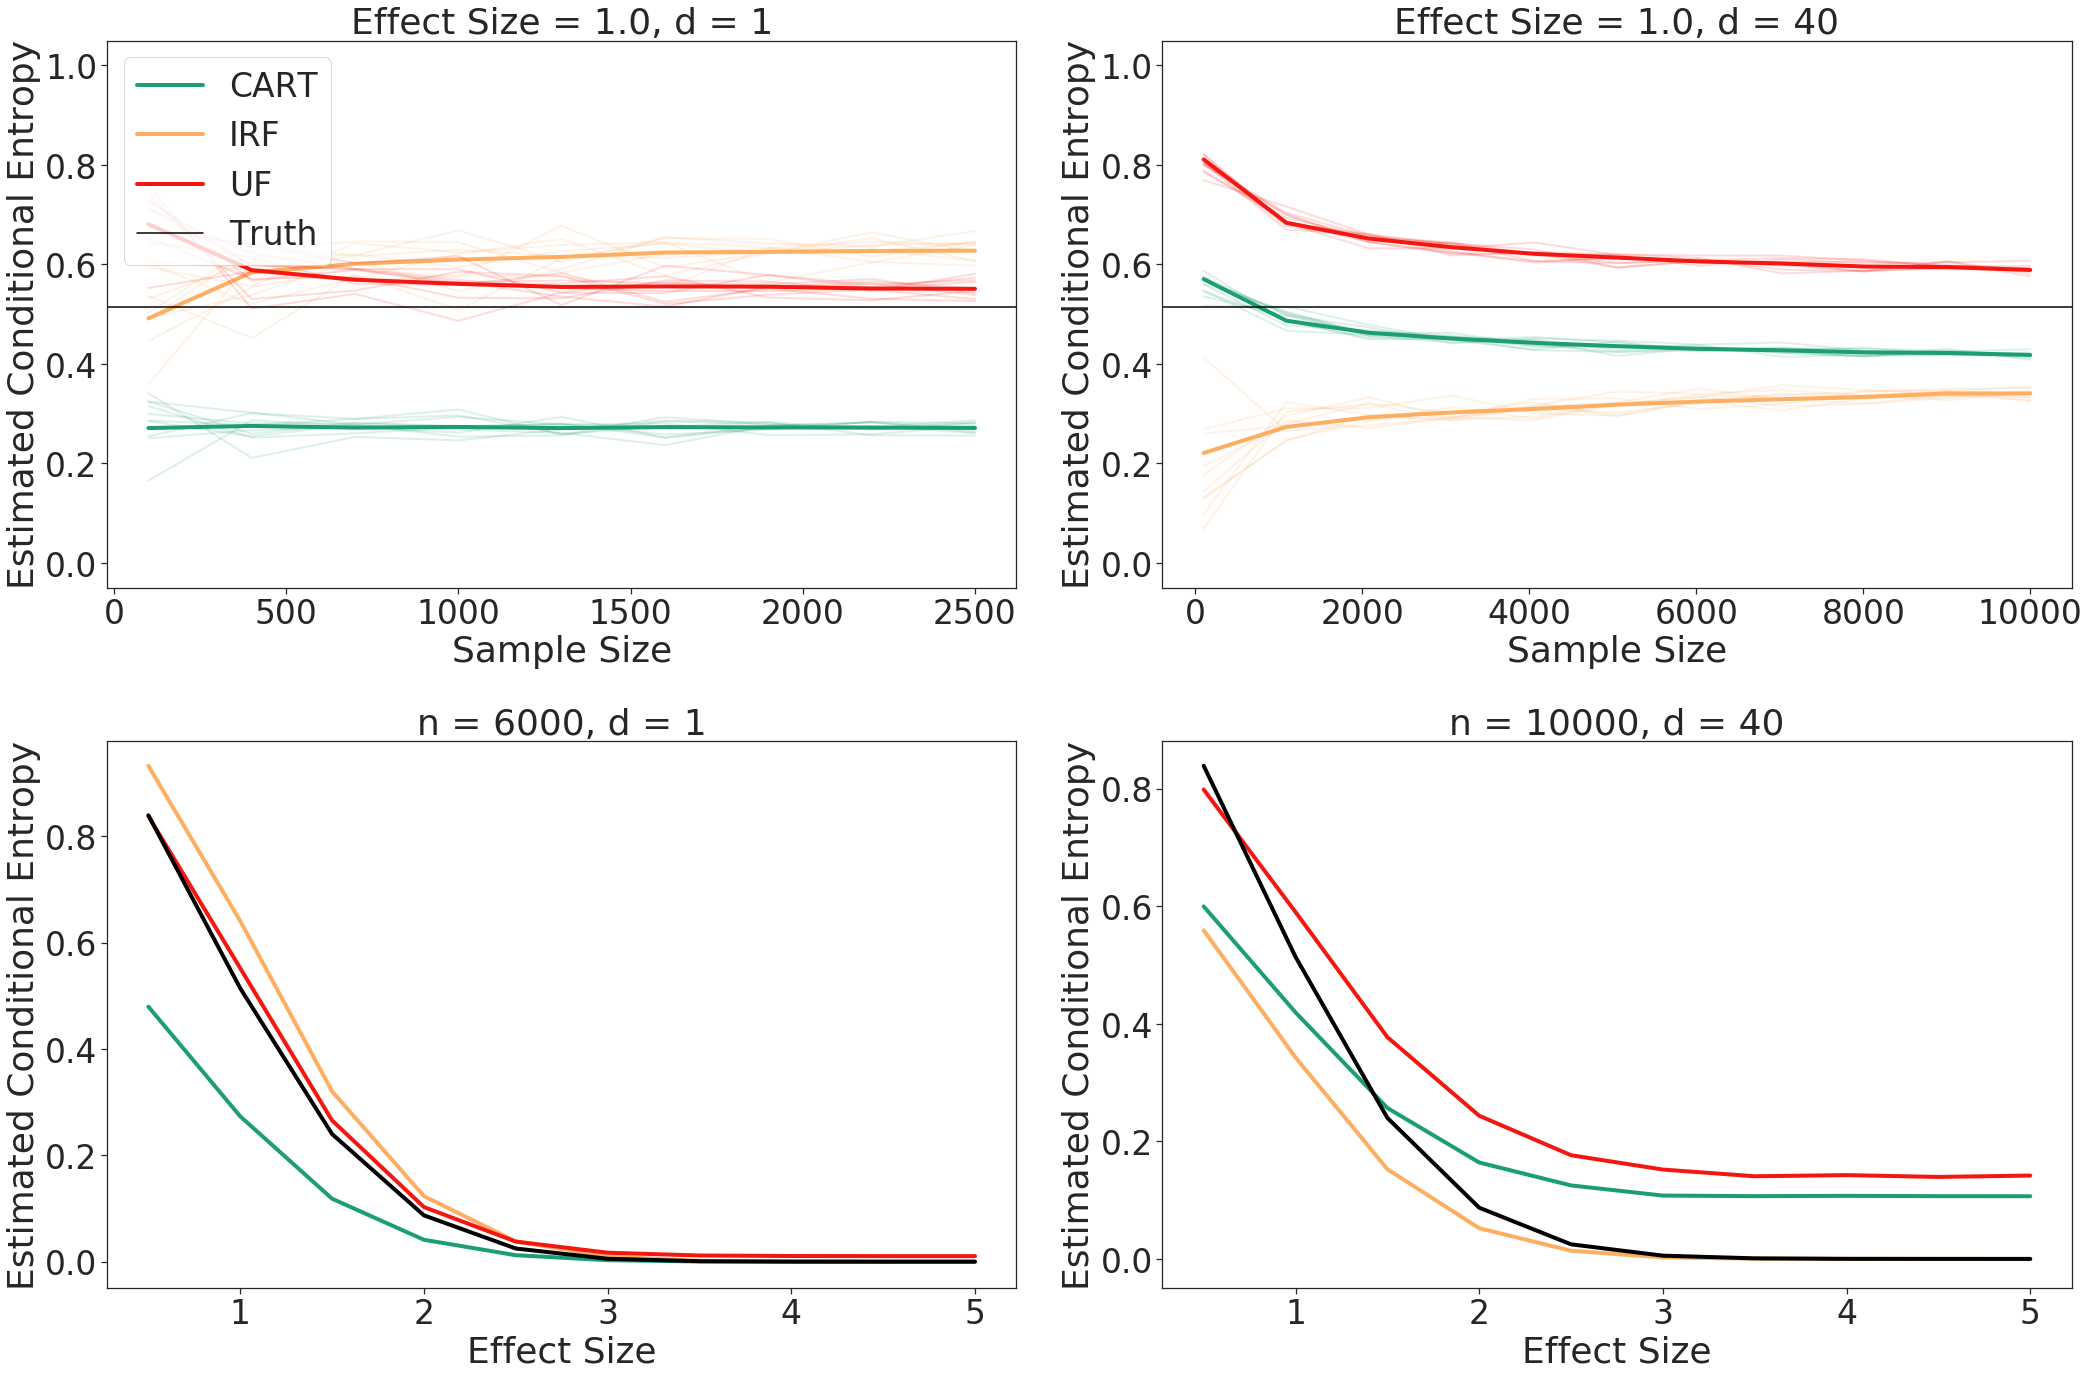

In [15]:
plot_fig2(num_plotted_trials, d1, d2, n1, n2)